## Loading Libraries

In [184]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.stats import ttest_ind
from sklearn.ensemble import IsolationForest
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats


## Loading the Data for the Month March

In [185]:
def fetch_train_data_for_date(date):
    day_api = f'https://rata.digitraffic.fi/api/v1/trains/{date}'
    response = requests.get(day_api)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for {date}. Status code: {response.status_code}")
        return None

def fetch_train_data_for_march_2024():
    year = 2024
    month = 3
    days_in_march = range(1, 32)  # days of the month march
    
    train_data_list = []
    
    for day in days_in_march:
        formatted_date = f'{year}-{month:02d}-{day:02d}' 
        train_data = fetch_train_data_for_date(formatted_date)
        if train_data:
            train_data_list.append(train_data)
    
    return train_data_list

# fetch the train data for the month march of the year 2024
train_data_march_2024 = fetch_train_data_for_march_2024()

# create a single list of all the dictionaries
list_dictionaries = [item for sublist in train_data_march_2024 for item in sublist]

# create dataframe from the train data of march 2024
df_march_2024 = pd.DataFrame(list_dictionaries)

# safe the dataframe to a csv file
df_march_2024.to_csv('data_march.csv', index=False)

# Save DataFrame with a list column
with open('dataframe.pkl', 'wb') as file:
    pickle.dump(df_march_2024, file)

In [186]:
# # Load DataFrame from the saved file, because if I load it from csv the objects become string and I want to eat my keyboard.
# with open('dataframe.pkl', 'rb') as file:
#     df_march_2024= pickle.load(file)

# Preliminary EDA and Visualizations

In [187]:
#  Iterate over each column in the DataFrame and print the column name and type
print("\nColumn names and data types:")
for column in df_march_2024.columns:
    print(f"Column: {column}, Type: {df_march_2024[column].dtype}")


Column names and data types:
Column: trainNumber, Type: int64
Column: departureDate, Type: object
Column: operatorUICCode, Type: int64
Column: operatorShortCode, Type: object
Column: trainType, Type: object
Column: trainCategory, Type: object
Column: commuterLineID, Type: object
Column: runningCurrently, Type: bool
Column: cancelled, Type: bool
Column: version, Type: int64
Column: timetableType, Type: object
Column: timetableAcceptanceDate, Type: object
Column: timeTableRows, Type: object


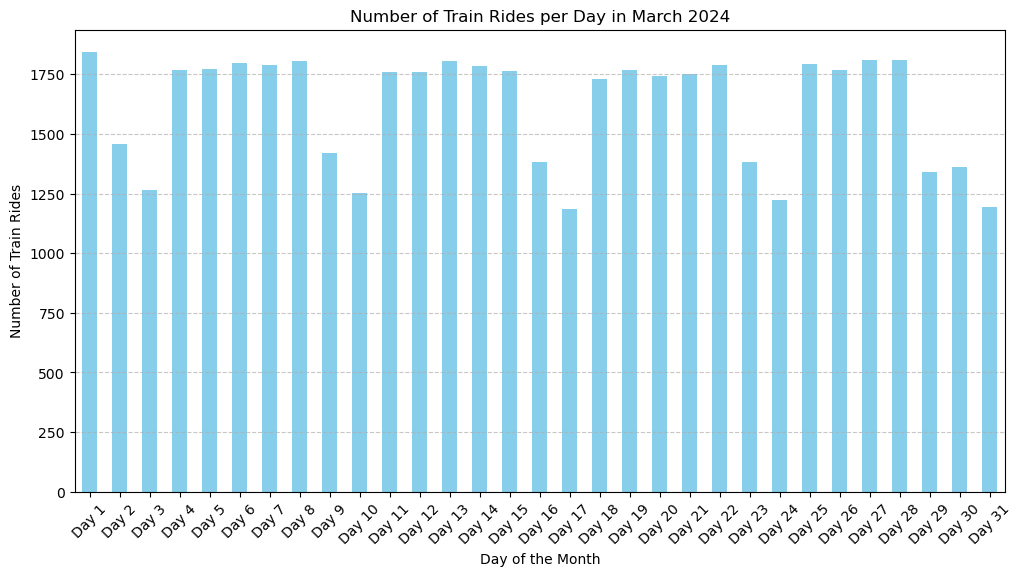

In [188]:
# Group by day of the month and count number of train rides per day
df_march_2024['departureDate'] = pd.to_datetime(df_march_2024['departureDate'])

# Group by day of the month and count number of train rides per day
train_rides_per_day = df_march_2024['departureDate'].dt.day.value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
train_rides_per_day.plot(kind='bar', color='skyblue')
plt.title('Number of Train Rides per Day in March 2024')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Train Rides')

day_labels = [f"Day {day}" for day in train_rides_per_day.index]
plt.xticks(range(len(train_rides_per_day)), day_labels, rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/l9/1t32pl1s7bs8hwtdsvql5l0h0000gn/T/ipykernel_1831/2498405240.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cancelled_true = cancelled_counts.get(1, 0)
/var/folders/l9/1t32pl1s7bs8hwtdsvql5l0h0000gn/T/ipykernel_1831/2498405240.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cancelled_false = cancelled_counts.get(0, 0)


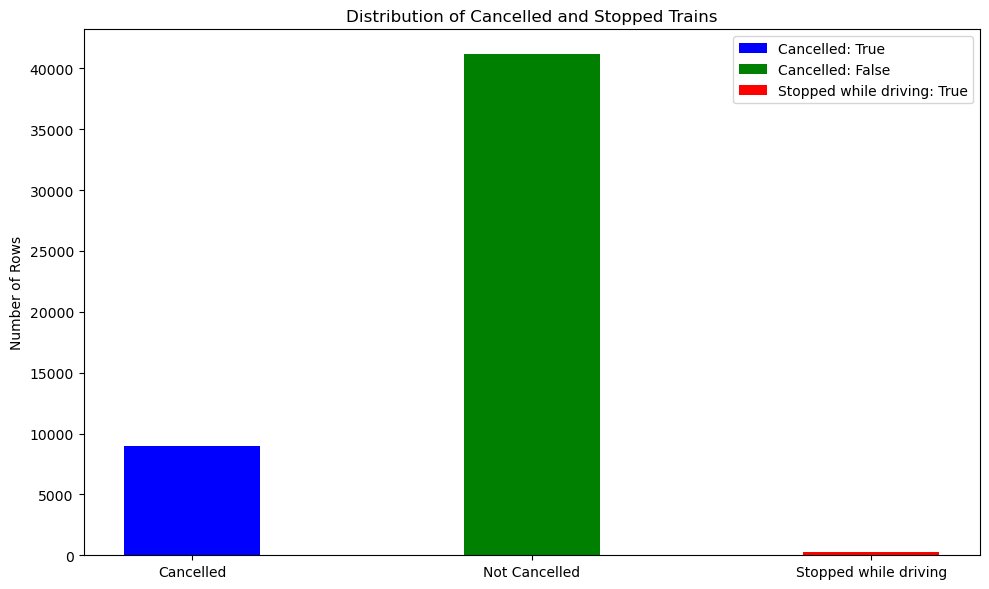

In [189]:
# Let's take a look at how often trains are running without cancelation, are cancelled or are stopped while driving
def stopped_while_driving(row):
    for station in row:
        if station.get("cancelled") == True:
            return True
    return False

# Apply the custom function to create the new column 'stopped_while_driving'
mask = df_march_2024['cancelled'] == False
df_march_2024.loc[mask, 'stopped_while_driving'] = df_march_2024.loc[mask, 'timeTableRows'].apply(stopped_while_driving)

# Fill missing values ('NaN') with False for rows where 'cancelled' == True
df_march_2024['stopped_while_driving'] = df_march_2024['stopped_while_driving'].fillna(False)

# Count the number of True and False in the "cancelled" and "stopped_while_driving" columns
cancelled_counts = df_march_2024['cancelled'].value_counts()
stopped_counts = df_march_2024['stopped_while_driving'].value_counts()

# Extract the values for the bars
cancelled_true = cancelled_counts.get(1, 0)
cancelled_false = cancelled_counts.get(0, 0)
stopped_true = stopped_counts.get(True, 0)

# Create the bar chart
plt.figure(figsize=(10, 6))

# Bar for "Cancelled: True"
plt.bar(0, cancelled_true, color='b', label='Cancelled: True', width=0.4)

# Bar for "Cancelled: False"
plt.bar(1, cancelled_false, color='g', label='Cancelled: False', width=0.4)

# Bar for "Stopped while driving: True"
plt.bar(2, stopped_true, color='r', label='Stopped while driving: True', width=0.4)

# Set x-axis labels
plt.xticks([0, 1, 2], ['Cancelled', 'Not Cancelled', 'Stopped while driving'])

# Set y-axis label and title
plt.ylabel('Number of Rows')
plt.title('Distribution of Cancelled and Stopped Trains')

# Show legend and display the chart
plt.legend()
plt.tight_layout()
plt.show()


# Data Preparation

In [190]:
#the number of unique values in the column "operatorUICCode" and the number of the unique values in the column "operatorShortCode" is the same, so i drop one of them.
df_march_2024 = df_march_2024.drop('operatorShortCode', axis=1)

# We can see that commuterLineID column has empty values
print(df_march_2024.commuterLineID.unique())

#replace the empty cells with the letter 'N' for 'no value' to make sure, the empty cells not cause problems later on
df_march_2024['commuterLineID'] = df_march_2024['commuterLineID'].replace('', 'N')

['' 'Z' 'H' 'O' 'M' 'A' 'E' 'U' 'L' 'Y' 'X' 'P' 'I' 'K' 'R' 'T' 'D' 'G'
 'V' 'W']


### Column "timeTableRows"

In [191]:
# discovering what is contained in the objects
print(f"The column contains {type(df_march_2024.timeTableRows.loc[0])} and the lists contain {type(df_march_2024.timeTableRows.loc[0][0])}")

# so the column contains a list of dictionaries. Each dictionary represents one stop of the train with all regarding information as delays, timestamp etc. 
# so now we know that this is the column, where the magic happens
# we need to create new features out of these dictionaries to be able to analyse the data finding anomalies concerning the number of the stations or the total time of a train from the start- to the endpoint.

The column contains <class 'list'> and the lists contain <class 'dict'>


In [243]:
#take a closer look at the first entry of the list 
df_march_2024.timeTableRows.loc[0][0]

{'stationShortCode': 'HKI',
 'stationUICCode': 1,
 'countryCode': 'FI',
 'type': 'DEPARTURE',
 'trainStopping': True,
 'commercialStop': True,
 'commercialTrack': '5',
 'cancelled': False,
 'scheduledTime': '2024-03-01T04:57:00.000Z',
 'actualTime': '2024-03-01T04:57:44.000Z',
 'differenceInMinutes': 1,
 'causes': [],
 'trainReady': {'source': 'KUPLA',
  'accepted': True,
  'timestamp': '2024-03-01T04:56:19.000Z'}}

## Extracting new Features out of the Column "timeTableRows"

### Feature 1: Number of Stops

In [193]:
#to get the number of stops we just divide by two.
# add a new column "nStops" to our existing dataframe 
# Calculate number of stations for each row and assign to new column 'nStops'
df_march_2024 ['nStops'] = df_march_2024 ['timeTableRows'].apply(lambda row: (len(row)/2))

### Feature 2: Return Trips

In [194]:
# i want to explore, if there are trains, that run back and forth between two stations and if yes, i want to identify those return trains
# counting the number of the first station to see if the train is a return train
def count_first_station_occurrences(row):
    first_station = row[0]["stationUICCode"]
    count = 0
    for station in row:
        if station["stationUICCode"] == first_station:
            count += 1
    return count

df_march_2024['first_station_count'] = df_march_2024['timeTableRows'].apply(count_first_station_occurrences)

# Count the number of return trips (where first_station_count > 1)
return_trips_count = (df_march_2024['first_station_count'] > 1).sum()

print(f"Number of trains doing return trips: {return_trips_count}")
# Calculate the percentage of trains doing return trips relative to the total population
total_trains = len(df_march_2024)
return_trips_percentage = (return_trips_count / total_trains) * 100

# Display the percentage
print(f"Percentage of trains doing return trips: {return_trips_percentage:.2f}%")

Number of trains doing return trips: 5795
Percentage of trains doing return trips: 11.57%


### Feature 3: Stopped While Driving

In [195]:
# I discovered in the timeTableRow, that there are train, that aren't cancelled but stopped while they are running. You can see that, because the key 'actual time' is missing later on and the key 'cancelled' is set to 'true'.
def stopped_while_driving(row):
    for station in row:
        if station.get("cancelled") == True:
            return True
    return False

# Apply the custom function to create the new column 'stopped_while_driving'
df_march_2024['stopped_while_driving'] = df_march_2024[df_march_2024['cancelled'] == False]['timeTableRows'].apply(stopped_while_driving)
mask = df_march_2024['cancelled'] == True
column_name = 'stopped_while_driving'
df_march_2024.loc[mask, column_name] = df_march_2024.loc[mask, column_name].fillna(False)


### Feature 4: Total Travel Time if the train is not cancelled

In [196]:
# calclulate the toal travel time from first until last stop by subtracting the key 'actualTime' of first from the key 'actualTime' of the last station
def calculate_travel_time(time_table_rows):
    try:
        # Extract 'actualTime' values from the first and last dictionaries
        first_actual_time = time_table_rows[0]['actualTime']
        last_actual_time = time_table_rows[-1]['actualTime']
        
        # Convert 'actualTime' strings to datetime objects
        first_time = datetime.strptime(first_actual_time, '%Y-%m-%dT%H:%M:%S.%fZ')
        last_time = datetime.strptime(last_actual_time, '%Y-%m-%dT%H:%M:%S.%fZ')
        
        # Calculate the total travel time in minutes
        travel_time = (last_time - first_time).total_seconds() / 60  # Convert seconds to minutes
        return travel_time
    
    except (KeyError, IndexError):
        return "stopped_premature"  # Hence I will only apply this function if the train is not cancelled, I only does not compute values 
    # if the train has started but not reached its destination and stopped on the way

# Apply the custom function to the 'timeTableRows' column of the DataFrame

df_march_2024['total_travel_time_minutes']  = df_march_2024[df_march_2024['cancelled'] == False]['timeTableRows'].apply(calculate_travel_time)

# Use loc to select the rows where 'cancelled' is True and the 'total_travel_time_minutes' column
mask = df_march_2024['cancelled'] == True
column_name = 'total_travel_time_minutes'
# this is complicated, do trais that get cancelled have a high or a low delay?
# While this might be a complicated and debatalbe question, both create the same outliers so I stick with 0
df_march_2024.loc[mask, column_name] = df_march_2024.loc[mask, column_name].fillna(0)


#### Investigate why total_travel_time_minutes returns NAT

In [197]:
# cancelled_df = df_march_2024.query("cancelled == True")
# count_nat_values = pd.isna(cancelled_df['total_travel_time_minutes']).sum()
# print(f"Given the train is cancelled {count_nat_values/len(cancelled_df)} percent of the total_travel_time_minutes column are NaT, which is kind of obvious when you think about it")
# # this was about 99,999 %

# nan_total_travel_time = df_march_2024.query("total_travel_time_minutes != total_travel_time_minutes")
# print(f" Given the total travel time is Nan {sum(nan_total_travel_time.cancelled)/len(nan_total_travel_time)} percent of the trains are cancelled. This demands further investigation")
# # this was around 90%. So there are some trains, that wheren't cancelled but still had the travel-time nan 

# nan_travel_but_not_cancelled = nan_total_travel_time.query("cancelled == False")

# print(nan_travel_but_not_cancelled.timeTableRows.iloc[0][91])
# print(nan_travel_but_not_cancelled.timeTableRows.iloc[0][92])
# print("so there are trains that are canclled while driving, which means, we cannot calculate their travelled time. This means we can replace with 0, where the whole train was cancelled but not for if the train is cancelled while driving.")
# print("Furthermore we need to create a feature stopped while driving")

# ## Filter rows where 'cancelled' is True and replace NaN in 'total_travel_time_minutes' with 0
# df_march_2024.loc[df_march_2024['cancelled'] == True, 'total_travel_time_minutes'].fillna(0, inplace=True)

### Feature 5: Total Travel Time if the Train is not cancelled but stops premature

In [198]:
def calculate_travel_time_premature_stop(time_table_rows):
    try:
        # Extract 'actualTime' values from the first and last dictionaries
        first_actual_time = time_table_rows[0]['actualTime']
        for number, station in enumerate(time_table_rows): 
            if station['cancelled'] == True:
                break
               
        last_actual_time = time_table_rows[number-1]['actualTime']
        
        # Convert 'actualTime' strings to datetime objects
        first_time = datetime.strptime(first_actual_time, '%Y-%m-%dT%H:%M:%S.%fZ')
        last_time = datetime.strptime(last_actual_time, '%Y-%m-%dT%H:%M:%S.%fZ')
        
        # Calculate the total travel time in minutes
        travel_time = (last_time - first_time).total_seconds() / 60  # Convert seconds to minutes
        return travel_time
    
    except (KeyError, IndexError):
        return 0 # The train was not cancellled, yet did never start

mask = df_march_2024['stopped_while_driving'] == True
column_name = 'total_travel_time_minutes'


df_march_2024.loc[mask, column_name] = df_march_2024.loc[mask, 'timeTableRows'].apply(calculate_travel_time_premature_stop)


### Feature 6: Cleaned Number of Stops for premature Stops

In [199]:
def calculate_stops_premature_stop(time_table_rows):
    try:
        # Extract 'actualTime' values from the first and last dictionaries
        for index, station in enumerate(time_table_rows): 
            if station['cancelled'] == True:
                break
        return index+1
    
    except (KeyError, IndexError):
        return 0 # The train was not cancellled, yet did never start

mask = df_march_2024['stopped_while_driving'] == True
column_name = 'nStops'

df_march_2024.loc[mask, column_name] = df_march_2024.loc[mask, 'timeTableRows'].apply(calculate_stops_premature_stop)


In [200]:
df_march_2024.query("total_travel_time_minutes == 'stopped_premature'").timeTableRows.loc[314][14]

{'stationShortCode': 'KY',
 'stationUICCode': 534,
 'countryCode': 'FI',
 'type': 'DEPARTURE',
 'trainStopping': False,
 'commercialTrack': '1',
 'cancelled': False,
 'scheduledTime': '2024-03-01T02:16:00.000Z',
 'actualTime': '2024-03-01T02:16:10.000Z',
 'differenceInMinutes': 0,
 'causes': []}

In [201]:
df_march_2024.query("total_travel_time_minutes == 'stopped_premature'").timeTableRows.loc[314][15]

{'stationShortCode': 'KLN',
 'stationUICCode': 981,
 'countryCode': 'FI',
 'type': 'ARRIVAL',
 'trainStopping': False,
 'commercialTrack': '1',
 'cancelled': False,
 'scheduledTime': '2024-03-01T02:20:21.000Z',
 'liveEstimateTime': '2024-03-01T02:20:05.000Z',
 'estimateSource': 'LIIKE_AUTOMATIC',
 'differenceInMinutes': 0,
 'causes': []}

In [202]:
# OK, so there are trains, that stop without being cancelled, but at this point, i will just delete them.
df_march_2024 = df_march_2024[df_march_2024['total_travel_time_minutes'] != 'stopped_premature']

In [203]:
# because we have deleted several rows, we have to reindex the df, because otherwise we will have a problem with the pca later on
df_march_2024.reset_index(drop=True, inplace=True) 

### Feature 7: Planned Travel Time

In [204]:
def calculate_planned_travel_time(time_table_rows):
    # Extract 'scheduledTime' values from the first and last dictionaries
    first_scheduled_time = time_table_rows[0]['scheduledTime']
    last_scheduled_time = time_table_rows[-1]['scheduledTime']
        
    # Convert 'scheduledTime' strings to datetime objects
    first_time = datetime.strptime(first_scheduled_time, '%Y-%m-%dT%H:%M:%S.%fZ')
    last_time = datetime.strptime(last_scheduled_time, '%Y-%m-%dT%H:%M:%S.%fZ')
        
    # Calculate the planned travel time in minutes
    planned_travel_time_minutes = (last_time - first_time).total_seconds() / 60
        
    return planned_travel_time_minutes
    
# Apply the custom function to the 'timeTableRows' column of the DataFrame
df_march_2024['planned_travel_time_minutes'] = df_march_2024['timeTableRows'].apply(calculate_planned_travel_time)

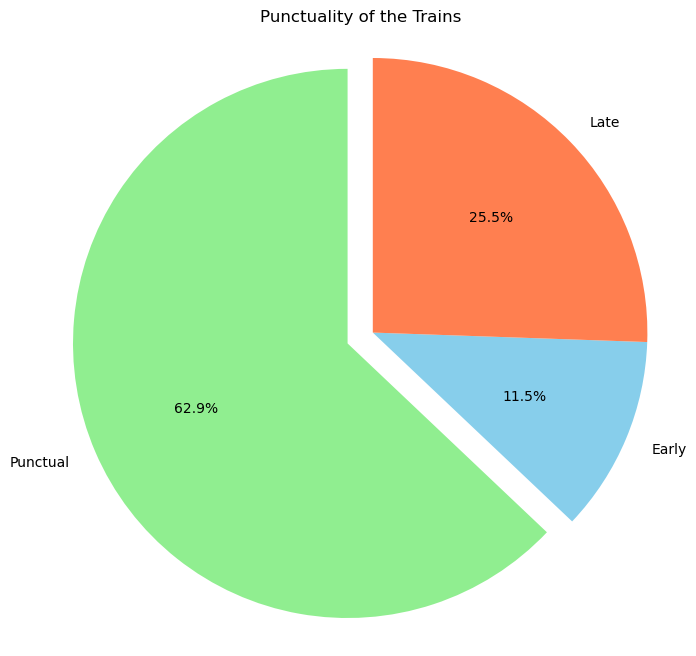

In [205]:
# display the relationship between the punctual trains, the late trains and the early trains
# create a copy of the original DataFrame to avoid modifying the original
df_punctuality = df_march_2024.copy()

# Categorization of the trains based on punctuality status
def categorize_punctuality(row):
    planned_time = row['planned_travel_time_minutes']
    actual_time = row['total_travel_time_minutes']
    cancelled = row['cancelled']
    stopped_while_driving = row['stopped_while_driving']
    
    if cancelled == 1 or stopped_while_driving == True:  # cancelled trains or trains, that are stopped while driving are considered late
        return 'late'
    elif abs(actual_time - planned_time) <= 3:  # Trains considered punctual within ±3 minutes
        return 'punctual'
    elif actual_time < planned_time:
        return 'early'
    else:
        return 'late'  # All other cases are classified as 'late'

# Add new column 'punctuality_status' based on categorization
df_punctuality['punctuality_status'] = df_punctuality.apply(categorize_punctuality, axis=1)

# Calculate percentage distribution for pie chart
punctual_count = (df_punctuality['punctuality_status'] == 'punctual').sum()
early_count = (df_punctuality['punctuality_status'] == 'early').sum()
late_count = (df_punctuality['punctuality_status'] == 'late').sum()
total_trains = len(df_punctuality)

# Calculate percentages
punctual_percent = (punctual_count / total_trains) * 100
early_percent = (early_count / total_trains) * 100
late_percent = (late_count / total_trains) * 100

# Data for the pie chart
labels = ['Punctual', 'Early', 'Late']
sizes = [punctual_percent, early_percent, late_percent]
colors = ['lightgreen', 'skyblue', 'coral']
explode = (0.1, 0, 0)  # Explode the 'Punctual' slice

# Create and display the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Punctuality of the Trains')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

### Feature 8: Total Delay by Departure

In [206]:
# Function to calculate total delay (sum of differences in minutes) for each row
def calculate_total_delay(row):
    total_delay = 0
    for entry in row:
        if entry.get('type') == 'DEPARTURE' and 'differenceInMinutes' in entry:
            total_delay += entry['differenceInMinutes']
    return total_delay

# Apply the calculate_total_delay function to each row in 'timeTableRows' column
df_march_2024['total_delay_minutes_departure'] = df_march_2024['timeTableRows'].apply(calculate_total_delay)

### Feature 9: Total Delay by Arrival

In [207]:
# Function to calculate total delay (sum of differences in minutes) for each row
def calculate_total_delay(row):
    total_delay = 0
    for entry in row:
        if entry.get('type') == 'ARRIVAL' and 'differenceInMinutes' in entry:
            total_delay += entry['differenceInMinutes']
    return total_delay

# Apply the calculate_total_delay function to each row in 'timeTableRows' column
df_march_2024['total_delay_minutes_arrival'] = df_march_2024['timeTableRows'].apply(calculate_total_delay)

In [208]:
# Evaluation if there is a correlation between the number of stops and the total delay by arrival
# Extract columns for analysis
total_delay_arrival = df_march_2024['total_delay_minutes_arrival']
n_stops = df_march_2024['nStops']

# Calculate correlation coefficient
correlation_coefficient = total_delay_arrival.corr(n_stops)

# Print the correlation coefficient
print("Correlation Coefficient (Pearson):", correlation_coefficient)

# There is a weak correlation bewtween the number of Stops and the total delay on arrival. As the number of stops increases, the total delay on arrival increases as well. But this correlation is not very strong.

Correlation Coefficient (Pearson): 0.2162196153761012


### Feature 10: Mean Delay Arrival and Departure per Stop


In [209]:
# this unfortunately causes the problem, that the trains, that are stopped while driving, have wrong delay-rates. If I had more time, it would be a task to improve.
# Calculate mean delay per station for each row
df_march_2024['mean_delay_per_station_arrival'] = df_march_2024['total_delay_minutes_arrival'] / df_march_2024['nStops'] 
# Calculate mean delay per station for each row
df_march_2024['mean_delay_per_station_departure'] = df_march_2024['total_delay_minutes_departure'] / df_march_2024['nStops'] 

### Feature 11: Maximum Delay

In [210]:
# Function to calculate the maximum 'differenceInMinutes', that means the maximum delay for all rows
def calculate_max_delay(row):
    max_delay = max(entry.get('differenceInMinutes', float('nan')) for entry in row)
    return max_delay

# Apply the calculate_max_difference_list function to each row in 'timeTableRows' column
df_march_2024['max_delay'] = df_march_2024['timeTableRows'].apply(calculate_max_delay)

#### Investigate the feature max_delay

In [211]:
cancelled_df = df_march_2024.query("cancelled == True")
count_nan_values = pd.isna(cancelled_df['max_delay']).sum()
print(f" Given the train is cancelled {count_nan_values/len(cancelled_df)} percent of the max_delay column are NaN")
nan_max_delay_nan = df_march_2024.query("max_delay != max_delay")
print(f" Given the max_delay is NaN {sum(nan_max_delay_nan.cancelled)/len(nan_max_delay_nan)} percent of the trains are cancelled. This is why I am replaceing NaN in max_delay with 0")
df_march_2024['max_delay'] = df_march_2024['max_delay'].fillna(0)

# the problem here is that the usage of the number zero is ambivalent, because it also implies, that the train is punctual. Yet, deleting all nan values would cause greater harm.

 Given the train is cancelled 0.9957494407158837 percent of the max_delay column are NaN
 Given the max_delay is NaN 0.9948591864103711 percent of the trains are cancelled. This is why I am replaceing NaN in max_delay with 0


### Feature 12: Station-ShortCodes as Columns (Bag of Words)

In [212]:
#Create a list of all stations for each row and then apply bag-of-words encoding so later on, it is possible to see, whether delays directly correspond to special stations
#extract the stationShortCode values and apply bag-of-words encoding
def extract_and_encode_stations(row):
    station_short_codes = [entry['stationShortCode'] for entry in row]
    station_short_code_counts = pd.Series(station_short_codes).value_counts()
    return station_short_code_counts

# Apply the function to each row of the "timeTableRows" column
station_counts_df = df_march_2024['timeTableRows'].apply(extract_and_encode_stations).fillna(0).astype(int)

# Concatenate the resulting DataFrame with the original DataFrame
# df_march_2024_w_stations_bow = pd.concat([df_march_2024, station_counts_df], axis=1)
df_march_2024 = pd.concat([df_march_2024, station_counts_df], axis=1)

#df_march_2024_w_stations_bow.head()

### Feature 13: Causes Categorys as Columns

In [213]:
#Create a list of all causes for each row and then apply bag-of-words encoding so later on, it is possible to see, whether delays directly correspond to special stations
#extract the stationShortCode values and apply bag-of-words encoding
# Function to extract causes from each row's timeTableRows list
def extract_causes(row):
    causes_list = []
    for item in row:
        causes_list.extend(item.get('causes'))
    return causes_list

# Create a new column 'causes_list' in the DataFrame with extracted causes
df_march_2024['causes_list'] = df_march_2024['timeTableRows'].apply(extract_causes)

In [214]:
# so i discovered another list of dictionaries in the key 'causes' that needs to be further examined... :P
# Function to extract the category letters from the list of dictionaries
def extract_category_letters(entries):
    if isinstance(entries, list) and len(entries) > 0:
        letters = [entry.get('categoryCode', '') for entry in entries]
        return [letter[0] for letter in letters if letter]  # Extract the first character of 'categoryCode' for each entry
    return []

# Apply the function to create a new column 'causesCategories'
df_march_2024['causesCategories'] = df_march_2024['causes_list'].apply(extract_category_letters)


#### Bag of Words

In [215]:
# to discover any hidden patterns in the causes, i run bag of words again
category_lists = df_march_2024['causesCategories'].explode().reset_index(drop=True)

# Count frequencies of each category code
category_counts = category_lists.value_counts()

# Create a set of all unique category codes
unique_categories = category_counts.index.tolist()

# Create a new DataFrame to hold the bag-of-words representation
bag_of_words_df = pd.DataFrame(0, index=df_march_2024.index, columns=unique_categories)

# Fill the bag-of-words DataFrame with category counts
for idx, categories in enumerate(df_march_2024['causesCategories']):
    if categories:  # Check if categories list is not empty
        category_counts = pd.Series(categories).value_counts()
        bag_of_words_df.loc[idx, category_counts.index] = category_counts

# Concatenate the bag-of-words DataFrame with the original DataFrame
df_march_2024 = pd.concat([df_march_2024, bag_of_words_df], axis=1)

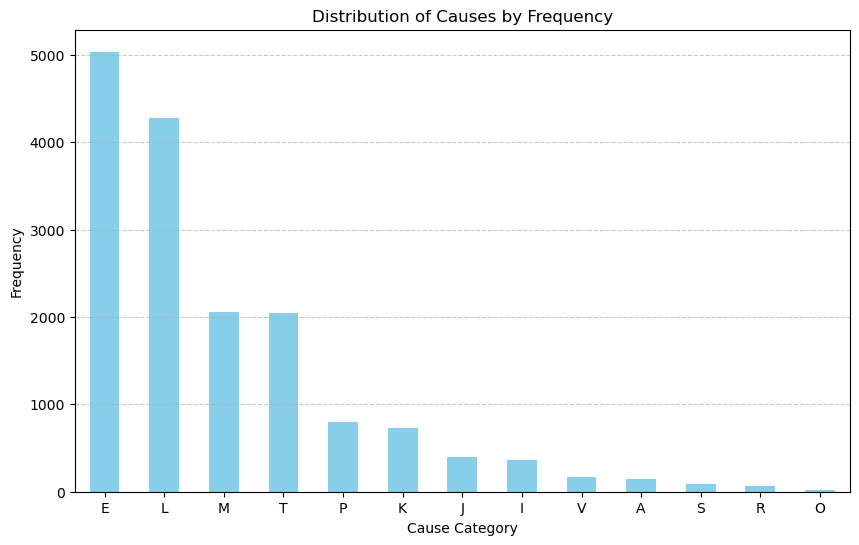

In [216]:
category_lists = df_march_2024['causesCategories'].explode().dropna()
category_counts = category_lists.value_counts()

# Sort categories by frequency
category_counts_sorted = category_counts.sort_values(ascending=False)

# Plotting the distribution of causes by frequency
plt.figure(figsize=(10, 6))
category_counts_sorted.plot(kind='bar', color='skyblue')

plt.title('Distribution of Causes by Frequency')
plt.xlabel('Cause Category')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines to y-axis

plt.show()

In [217]:
# So it is ovious, that there are causes like 'E' and 'L' that appear more often then the others

### Feature 14: Trains from Finnland or not

In [219]:
#Create a list of all causes for each row and then apply bag-of-words encoding so later on, it is possible to see, whether delays directly correspond to special stations
#extract the stationShortCode values and apply bag-of-words encoding
# Function to extract causes from each row's timeTableRows list
def extract_country(row):
    for item in row:
        if item.get('countryCode') != "FI":
            return 0
        else:
            return 1

# Create a new column 'causes_list' in the DataFrame with extracted causes
df_march_2024['finnland'] = df_march_2024['timeTableRows'].apply(extract_country)

In [220]:
df_march_2024['finnland'].value_counts()

finnland
1    49277
0       40
Name: count, dtype: int64

## Encoding of Categorial Variables or Creation of Integer Values where possible (mostly date related)
In the next step, the categorial variables need to be encoded, so that the clustering works later on

In [221]:
df_march_2024['departureDate'] = pd.to_datetime(df_march_2024['departureDate']).dt.day

In [222]:
df_march_2024.timetableAcceptanceDate = pd.to_datetime(df_march_2024.timetableAcceptanceDate)
min_date = df_march_2024['timetableAcceptanceDate'].min()
df_march_2024['timedelta_timetableAcceptanceData'] = df_march_2024['timetableAcceptanceDate'] - min_date
df_march_2024['timedelta_timetableAcceptanceData'] = df_march_2024['timedelta_timetableAcceptanceData'].dt.days
df_march_2024.drop(columns="timetableAcceptanceDate", inplace=True)

In [223]:
df_march_2024.runningCurrently.replace(False, 0, inplace=True)
df_march_2024.runningCurrently.replace(True, 1, inplace=True)
df_march_2024.cancelled.replace(False, 0, inplace=True)
df_march_2024.cancelled.replace(True, 1, inplace=True)
df_march_2024.stopped_while_driving.replace(False, 0, inplace=True)
df_march_2024.stopped_while_driving.replace(True, 1, inplace=True)

In [224]:
# because verison has high cardinality goodbye
print(df_march_2024.version.nunique())
df_march_2024.drop(columns="version", inplace=True)
# also the train number has an insanely hihg cardinality thus goodbye
df_march_2024_wo_train = df_march_2024.drop(columns="trainNumber")
# because we will start now with clustering and pca I will drop the timeTableRows
df_march_2024_wo_train.drop(columns="timeTableRows", inplace=True)
# because i have extracted all information i will drop also causesCategories and causes_list
df_march_2024_wo_train.drop(columns='causes_list', inplace=True)
df_march_2024_wo_train.drop(columns='causesCategories',inplace=True)

42674


# One Hot Encolding to deal with leftover categorial Values

In [225]:
columns = df_march_2024_wo_train.columns

# Initialize lists to store column types
numerical_columns = []
categorical_columns = []

# Iterate through each column to determine its type
for column in columns:
    # Check if the column dtype is numeric (int or float)
    if pd.api.types.is_numeric_dtype(df_march_2024_wo_train[column]):
        numerical_columns.append(column)
    else:
        categorical_columns.append(column)

In [226]:
categorical_columns.append("operatorUICCode")
categorical_columns.remove('total_travel_time_minutes')

In [227]:
# now lets one hot encoded, the cardinality is high yet I do not want to delete the trainNumber column
df_encoded = pd.get_dummies(df_march_2024_wo_train, columns=categorical_columns,  dtype=int)

# Run a PCA to deal with the high Number of Features

In [228]:
# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)

# Step 2: Perform PCA to capture 85% of the variance
desired_variance = 0.95
pca = PCA(n_components=desired_variance, svd_solver='full')  # Specify desired variance as n_components

# Fit PCA to scaled data
pca_result = pca.fit_transform(scaled_data)

# Calculate cumulative explained variance ratio
explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum()

# Determine the number of components that capture desired variance
n_components = (explained_variance_ratio_cumsum < desired_variance).sum() + 1

# Re-apply PCA with the determined number of components
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame for PCA results
pca_columns = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

# Run Isolation Forest efficiently detect Outliers after running the PCA

In [229]:
# i made the decision to run an isolation forest after performing the pca because we are dealing with a high-dimension data set and we want to detect outliers
# Isolation Forest uses random partitioning to isolate anomalies

# standardize the data (if needed)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_df)

# apply Isolation Forest for anomaly detection
isoforest = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination based on outlier proportion
isoforest.fit(scaled_data)

# predict anomaly scores (-1 for outliers, 1 for inliers)
anomaly_scores = isoforest.predict(scaled_data)

# add anomaly scores to pca_df
pca_df['anomaly_score'] = anomaly_scores

# display anomaly scores and identify outliers
outliers = pca_df[pca_df['anomaly_score'] == -1]

# display outliers
print("Number of outliers detected:", len(outliers))

Number of outliers detected: 2466


In [230]:
pca_df.query('anomaly_score == -1').index

Index([   14,    15,    20,    25,    27,    32,    39,    49,    74,    76,
       ...
       48492, 49094, 49095, 49148, 49169, 49174, 49297, 49298, 49299, 49300],
      dtype='int64', length=2466)

In [231]:
# Get the indices of outlier instances from pca_df
outlier_indices = pca_df.query('anomaly_score == -1').index

# Filter the original dataset to show outlier instances
df_outliers = df_march_2024.loc[outlier_indices]
df_no_outliers = df_march_2024.drop(outlier_indices)

# Visualizations for Comparison of Categorial Features

## Feature: TrainCategory

### Visualization

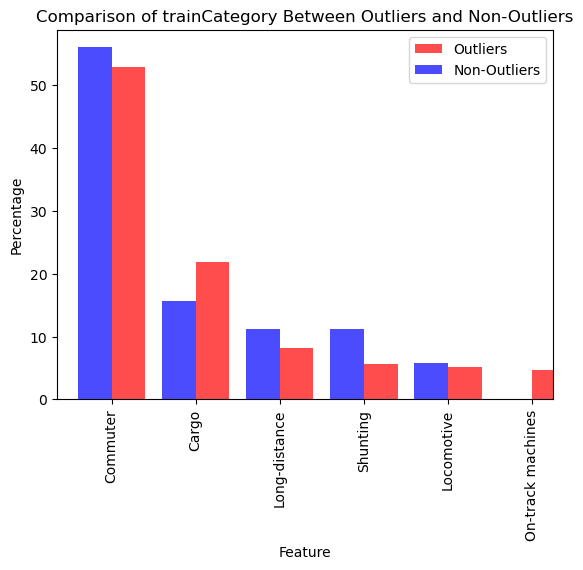

In [232]:
feature_name = "trainCategory"

# Calculate percentage of each category in df_outlier
outlier_counts = df_outliers[feature_name].value_counts(normalize=True) * 100

# Calculate percentage of each category in df_no_outlier
no_outlier_counts = df_no_outliers[feature_name].value_counts(normalize=True) * 100

# Create a bar plot
fig, ax = plt.subplots()

# Plotting bars for df_outlier
outlier_counts.plot(kind='bar', color='red', ax=ax, position=0, width=0.4, label='Outliers', alpha=0.7)

# Plotting bars for df_no_outlier
no_outlier_counts.plot(kind='bar', color='blue', ax=ax, position=1, width=0.4, label='Non-Outliers', alpha=0.7)

# Customize the plot
ax.set_xlabel('Feature')
ax.set_ylabel('Percentage')
ax.set_title(f'Comparison of {feature_name} Between Outliers and Non-Outliers')
ax.legend()

# Show the plot
plt.show()

### Test

In [233]:
# to compare the df_outlier with the df_no_outliers concerning the categorial variable trainCategory, i use a chi-squared test of independence. This tells us, if the observed frequency distribution differs significally
# Set the number of random samples to pick
sample_size = len(df_outliers)

# Set the number of iterations (repeats)
num_iterations = 100

# Create a list to store sampled 'trainCategory' Series
sampled_categories = []

# List for test-results
chi2_results = []

# Loop through each iteration
for i in range(num_iterations):
    # Draw a random sample from df_outliers
    sampled_no_outliers = df_no_outliers.sample(n=sample_size, replace=False, random_state=i)
    
    # Get category counts for the sample from df_outliers
    sampled_no_outliers_counts = sampled_no_outliers['trainCategory'].value_counts()
    
    # Get category counts for df_no_outliers
    outliers_counts = df_outliers['trainCategory'].value_counts()
    
    # Create a DataFrame to perform chi-squared test
    df_chi2 = pd.DataFrame({
        'sampled_no_outliers': sampled_no_outliers_counts,
        'no_outliers': outliers_counts
    }).fillna(0)  # Fill NaN values with 0 in case a category is missing in one DataFrame
    
    # Perform chi-squared test of independence
    chi2_stat, p_value, dof, _ = chi2_contingency(df_chi2)
    
    # Append results to the list
    chi2_results.append((chi2_stat, p_value))

chi2_square_mean = sum(chi2_results[0])/len(chi2_results)

p_value_mean = stats.chi2.sf(chi2_square_mean , dof)

print(p_value_mean)

 # there is a significant difference in the distribution of trainCategory between df_outliers and df_no_outliers

0.005756289223571075


## Feature: trainType

### Visualization

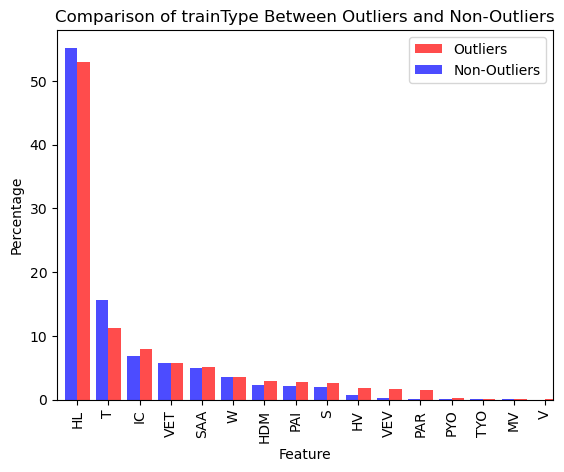

In [234]:
feature_name = "trainType"

# Calculate percentage of each category in df_outlier
outlier_counts = df_outliers[feature_name ].value_counts(normalize=True) * 100

# Calculate percentage of each category in df_no_outlier
no_outlier_counts = df_no_outliers[feature_name ].value_counts(normalize=True) * 100

# Create a bar plot
fig, ax = plt.subplots()

# Plotting bars for df_outlier
outlier_counts.plot(kind='bar', color='red', ax=ax, position=0, width=0.4, label='Outliers', alpha=0.7)

# Plotting bars for df_no_outlier
no_outlier_counts.plot(kind='bar', color='blue', ax=ax, position=1, width=0.4, label='Non-Outliers', alpha=0.7)

# Customize the plot
ax.set_xlabel('Feature')
ax.set_ylabel('Percentage')
ax.set_title(f'Comparison of {feature_name} Between Outliers and Non-Outliers')
ax.legend()

# Show the plot
plt.show()

## Feature: operatorUICCode

### Visualization

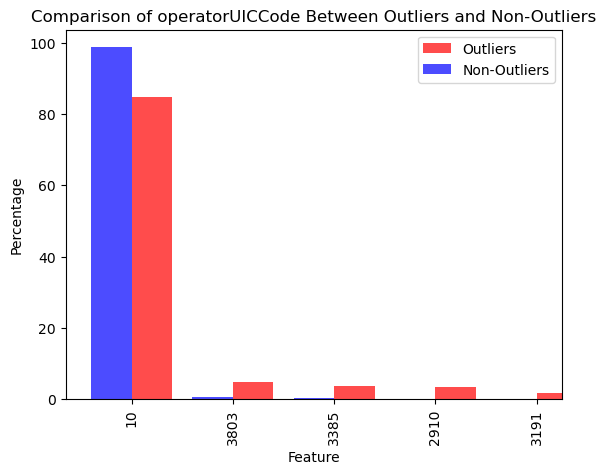

In [235]:
feature_name = "operatorUICCode"

# Calculate percentage of each category in df_outlier
outlier_counts = df_outliers[feature_name ].value_counts(normalize=True) * 100

# Calculate percentage of each category in df_no_outlier
no_outlier_counts = df_no_outliers[feature_name ].value_counts(normalize=True) * 100

# Create a bar plot
fig, ax = plt.subplots()

# Plotting bars for df_outlier
outlier_counts.plot(kind='bar', color='red', ax=ax, position=0, width=0.4, label='Outliers', alpha=0.7)

# Plotting bars for df_no_outlier
no_outlier_counts.plot(kind='bar', color='blue', ax=ax, position=1, width=0.4, label='Non-Outliers', alpha=0.7)

# Customize the plot
ax.set_xlabel('Feature')
ax.set_ylabel('Percentage')
ax.set_title(f'Comparison of {feature_name} Between Outliers and Non-Outliers')
ax.legend()

# Show the plot
plt.show()

## Feature: timetableType

### Visualization

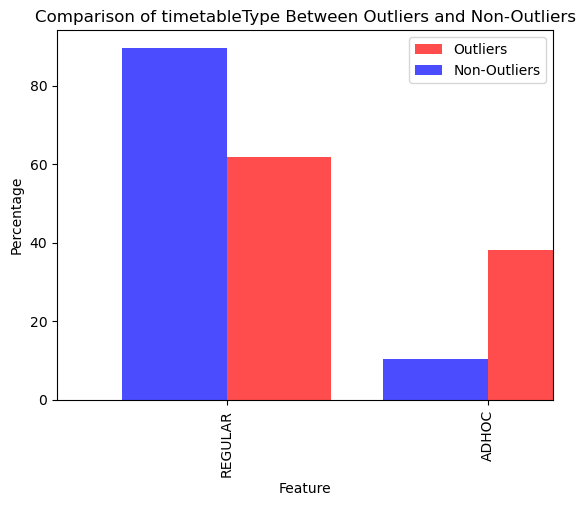

In [236]:
feature_name = "timetableType"

# Calculate percentage of each category in df_outlier
outlier_counts = df_outliers[feature_name ].value_counts(normalize=True) * 100

# Calculate percentage of each category in df_no_outlier
no_outlier_counts = df_no_outliers[feature_name ].value_counts(normalize=True) * 100

# Create a bar plot
fig, ax = plt.subplots()

# Plotting bars for df_outlier
outlier_counts.plot(kind='bar', color='red', ax=ax, position=0, width=0.4, label='Outliers', alpha=0.7)

# Plotting bars for df_no_outlier
no_outlier_counts.plot(kind='bar', color='blue', ax=ax, position=1, width=0.4, label='Non-Outliers', alpha=0.7)

# Customize the plot
ax.set_xlabel('Feature')
ax.set_ylabel('Percentage')
ax.set_title(f'Comparison of {feature_name} Between Outliers and Non-Outliers')
ax.legend()

# Show the plot
plt.show()

# So as we can see, in the population of non-outliers, there are much more regular trains and less adhoc trains and in the population of outliers it is the other way around.

## Feature: operatorCode

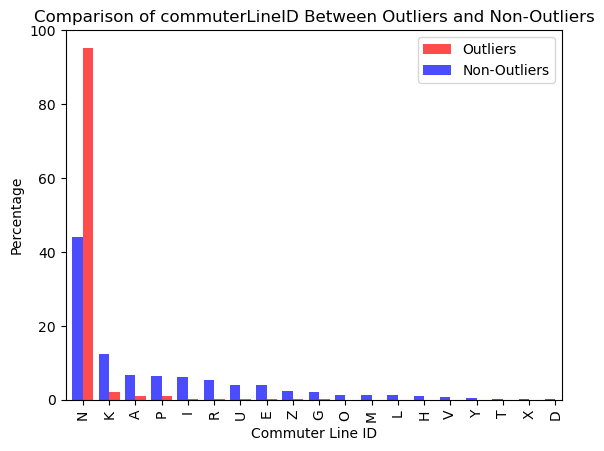

In [237]:
feature_name = "commuterLineID"

# Calculate percentage of each category in df_outliers
outlier_counts = df_outliers[feature_name].value_counts(normalize=True) * 100

# Calculate percentage of each category in df_no_outliers
no_outlier_counts = df_no_outliers[feature_name].value_counts(normalize=True) * 100

# Create a bar plot
fig, ax = plt.subplots()

# Plotting bars for df_outliers
outlier_counts.plot(kind='bar', color='red', ax=ax, position=0, width=0.4, label='Outliers', alpha=0.7)

# Plotting bars for df_no_outliers
no_outlier_counts.plot(kind='bar', color='blue', ax=ax, position=1, width=0.4, label='Non-Outliers', alpha=0.7)

# Customize the plot
ax.set_xlabel('Commuter Line ID')
ax.set_ylabel('Percentage')
ax.set_title(f'Comparison of {feature_name} Between Outliers and Non-Outliers')
ax.legend()

# Show the plot
plt.show()

so this seems to be the most interesting thing so far. In the outliers case we have much more non-commuter trains.

### Test

In [238]:
# perform a z-test to investigate the proportions of the two populations
n_outliers_commuter_train = (df_outliers['commuterLineID'] == 'N').sum()
lenght_outliers = len(df_outliers['commuterLineID'])

n_no_outliers_commuter_train = (df_no_outliers['commuterLineID'] == 'N').sum()
lenght_no_outliers = len(df_no_outliers['commuterLineID'])

# perform z-test
count = np.array([n_outliers_commuter_train , n_no_outliers_commuter_train])
nobs = np.array([lenght_outliers , lenght_no_outliers])

z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

# Print the Z-statistic and p-value
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# set significance level to 95%
alpha = 0.05  
if p_value < alpha:
    print("Reject the null hypothesis: Proportions are significantly different.")
else:
    print("Fail to reject the null hypothesis: Proportions are not significantly")

# ok, there is a significantly differece in the CommuterLineIDs in the population of outliers and non-outliers

Z-statistic: 49.7215
P-value: 0.0000
Reject the null hypothesis: Proportions are significantly different.


# Visualizations and Tests for Comparison of Numerical Features 

## Feature: nStations

### Visualization

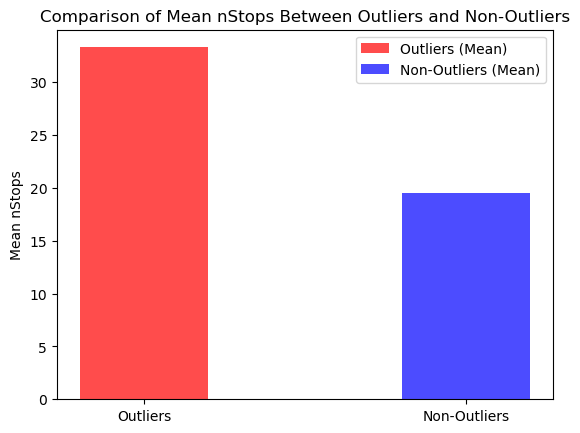

In [239]:
# Calculate mean of nStops in df_outliers and df_no_outliers
outlier_mean = df_outliers['nStops'].mean()
no_outlier_mean = df_no_outliers['nStops'].mean()

# Create a bar plot
fig, ax = plt.subplots()

# Plotting bars for mean of df_outliers
ax.bar(0, outlier_mean, color='red', width=0.4, label='Outliers (Mean)', alpha=0.7)

# Plotting bars for mean of df_no_outliers
ax.bar(1, no_outlier_mean, color='blue', width=0.4, label='Non-Outliers (Mean)', alpha=0.7)

# Customize the plot
ax.set_xticks([0, 1])
ax.set_xticklabels(['Outliers', 'Non-Outliers'])
ax.set_ylabel('Mean nStops')
ax.set_title('Comparison of Mean nStops Between Outliers and Non-Outliers')
ax.legend()

# Show the plot
plt.show()
# So as we see, there is a signifcant difference in the mean of the number of Stops. So we can conclude, that one aspect, that define the outliers are a high number of stops


### Test

In [240]:
# Extract the "stations" column from df_not_outliers and df_outliers
stations_not_outliers = df_no_outliers['nStops']
stations_outliers = df_outliers['nStops']

# Perform t-test to compare the means of "stations" between the two datasets
t_statistic, p_value = ttest_ind(stations_not_outliers, stations_outliers)

# Display the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

print(np.mean(stations_not_outliers))
print(np.mean(stations_outliers))

# ok, this is highly significant, so we know, that the difference between the outliers and the not outliers has something to do with the number of stops
# Furthermore we know that the outliers have more stops.

T-Statistic: -35.34067006376531
P-Value: 3.3676617321115067e-270
19.554908112953832
33.305352798053526


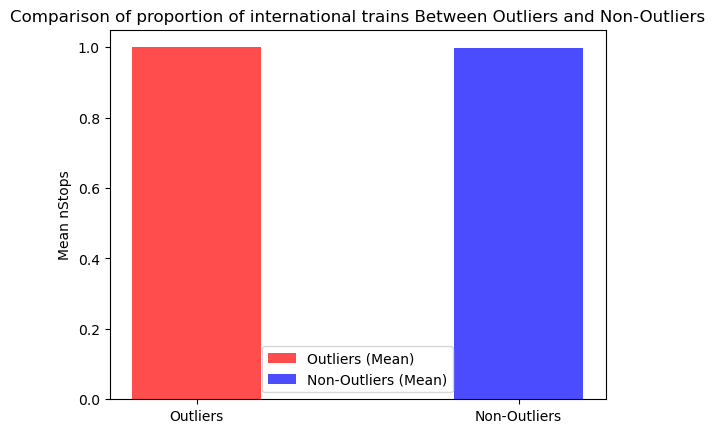

In [241]:
# Calculate mean of nStops in df_outliers and df_no_outliers
outlier_mean = df_outliers['finnland'].mean()
no_outlier_mean = df_no_outliers['finnland'].mean()

# Create a bar plot
fig, ax = plt.subplots()

# Plotting bars for mean of df_outliers
ax.bar(0, outlier_mean, color='red', width=0.4, label='Outliers (Mean)', alpha=0.7)

# Plotting bars for mean of df_no_outliers
ax.bar(1, no_outlier_mean, color='blue', width=0.4, label='Non-Outliers (Mean)', alpha=0.7)

# Customize the plot
ax.set_xticks([0, 1])
ax.set_xticklabels(['Outliers', 'Non-Outliers'])
ax.set_ylabel('Mean nStops')
ax.set_title('Comparison of proportion of international trains Between Outliers and Non-Outliers')
ax.legend()

# Show the plot
plt.show()
# So as we see, there is a signifcant difference in the mean of the number of Stops. So we can conclude, that one aspect, that define the outliers are a high number of stops


In [242]:
# perform a z-test to investigate the proportions of the two populations
n_outliers_commuter_train = (df_outliers['finnland'] == 0).sum()
lenght_outliers = len(df_outliers['finnland'])

n_no_outliers_commuter_train = (df_no_outliers['finnland'] == 0).sum()
lenght_no_outliers = len(df_no_outliers['finnland'])

# perform z-test
count = np.array([n_outliers_commuter_train , n_no_outliers_commuter_train])
nobs = np.array([lenght_outliers , lenght_no_outliers])

z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

# Print the Z-statistic and p-value
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# set significance level to 95%
alpha = 0.05  
if p_value < alpha:
    print("Reject the null hypothesis: Proportions are significantly different.")
else:
    print("Fail to reject the null hypothesis: Proportions are not significantly different")

Z-statistic: -1.4516
P-value: 0.1466
Fail to reject the null hypothesis: Proportions are not significantly different


# Conclusion:

During the EDA, I found out that the 'timeTableRows' column contains a lot of important information that was essential for the later analysis. For this reason, I built various new features from this column like 'nStops', 'causes' etc. In order to take into account the 'stationShortCodes' and the different 'causes' in the later anomaly detection, I applied Bag of Words to these two columns. Afterwardds I encoded the categorical features with one hot encoding to make them be usable with a algorithm. 

Furthermore (not included) I also used Gower Distance, and got the same results, yet to make the code here clear and concise I deleted that approach.
 
To deal with the large number of features, I first ran a PCA and then determined the outliers using an isolation forest. I then analyzed the differences between the outliers and no-outliers with the help of visualizations for the categorical and numerical features and analyzed the differences with the help of statical tests such as t-test, z-test and chi-squared tests. 

The most important findings: the two populations outliers and no-outliers differ significantly in terms of 'trainCategory', 'commuterLineID' and 'nStops'. For example, long-distance trains appear more often within the outliers than within the no-outliers. This is also reflected in the significantly higher average number of stops for the outliers. 

Generally outlier detection is different from clustering regarding the fact that outliers do not need to be a coherent cluster, the similiarity between outliers is not their cohesion but their difference between them an the non outlier group.

What could be done in the future here:
1. Create more features out of the time table row
2. Do more statistical tests.
3. Create more dataframes from different distance metrics (Gower Distance) and dataframes from different outlier detection algorithms.

